In [8]:
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

### Step 1: Read data

In [9]:
ds = xr.open_dataset(
    '/g/data/xv83/dbi599/treasury/wsdi_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_18500101-21001231.nc',
    decode_timedelta=False,
)

In [10]:
ds = ds.drop_vars(['height', 'percentiles'])

In [11]:
del ds['WSDI'].attrs['cell_methods']

### Step 2: Read shapefiles

In [12]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [13]:
states_gp = states_gp.drop(columns=['AREASQKM21', 'LOCI_URI21'])

In [14]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australian Capital Territory,ACT,"POLYGON ((149.06239 -35.1591, 149.09134 -35.14..."
8,Other Territories,OT,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748..."


We're working with a coarse resolution model with grid cells much larger than the ACT and other territories, so we'll leave those out:

In [15]:
states_gp = states_gp[:-2]

In [16]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."


In [17]:
aus_gp = states_gp.dissolve()
aus_gp['STE_NAME21'] = 'Australia'
aus_gp['ABBREV'] = 'AUS'

In [18]:
aus_gp

,geometry,STE_NAME21,ABBREV
0,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -...",Australia,AUS


In [19]:
states_gp = pd.concat([states_gp, aus_gp], ignore_index=True)

In [20]:
states_gp

,STE_NAME21,ABBREV,geometry
0,New South Wales,NSW,"MULTIPOLYGON (((159.0623 -31.50886, 159.06218 ..."
1,Victoria,VIC,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,Queensland,QLD,"MULTIPOLYGON (((142.5314 -10.68301, 142.53072 ..."
3,South Australia,SA,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,Western Australia,WA,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."
5,Tasmania,TAS,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443..."
6,Northern Territory,NT,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982..."
7,Australia,AUS,"MULTIPOLYGON (((113.96119 -28.986, 113.96137 -..."


We now need to turn our geopandas GeoDataFrame into a regionmask Regions object:

In [21]:
type(states_gp)

geopandas.geodataframe.GeoDataFrame

In [22]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states",
)

In [23]:
type(states_regions)

regionmask.core.regions.Regions

In [24]:
print(states_regions)

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory
7 AUS          Australia

[8 regions]


### Step 3: Create a mask

We can use the `mask_3D_frac_approx` method to calculate the fraction of each grid cell that overlaps with each shape:

In [25]:
frac = states_regions.mask_3D_frac_approx(ds)

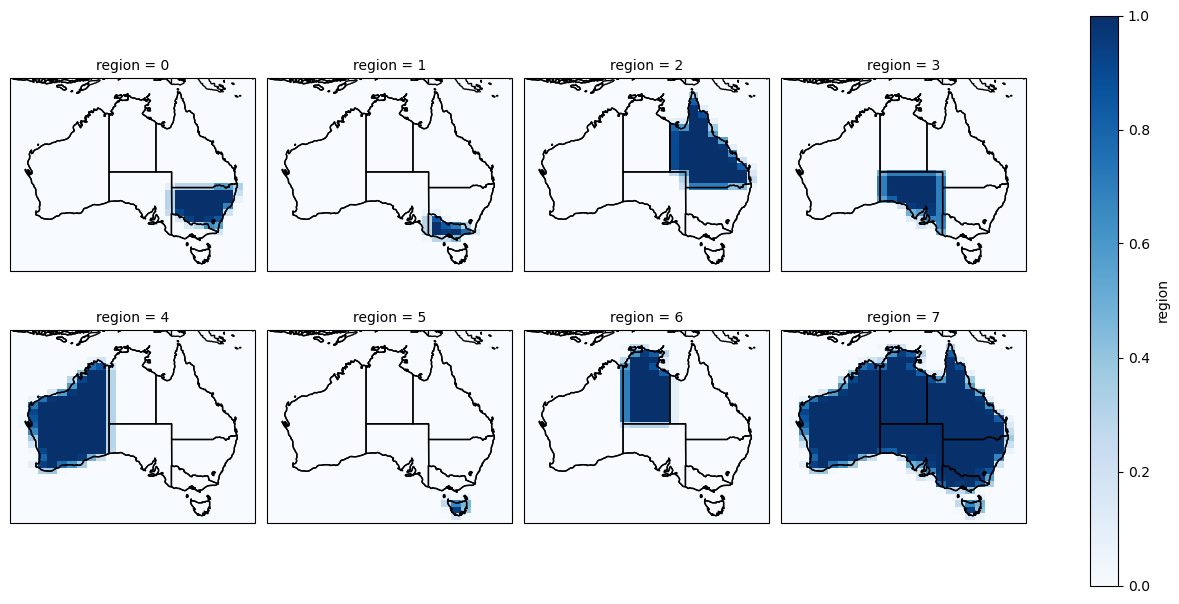

In [26]:
fg = frac.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    cmap='Blues',
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
plt.show()

### Step 4: Calculate a (weighted) regional mean

In [27]:
weights = np.cos(np.deg2rad(ds['lat']))

The most accurate spatial mean method is to multiply `weights` by the fractional overlap (`frac`) that we calculated earlier. That will ensure that an appropriate fractional value of the grid cells that are on the edge of the state/territory get included in the weighted average:

In [28]:
spatial_means = ds['WSDI'].weighted(frac * weights).mean(dim=("lat", "lon"))

In [29]:
print(spatial_means)

<xarray.DataArray 'WSDI' (time: 251, region: 8)> Size: 16kB
array([[1.39796987e+00, 2.30216968e+00, 9.06113806e-02, ...,
        1.79819250e+00, 0.00000000e+00, 5.73543791e-01],
       [5.98423288e+00, 4.86910295e+00, 2.83129303e+00, ...,
        8.93470212e+00, 4.55734561e+00, 3.15473911e+00],
       [4.20956635e+00, 2.19849278e+00, 1.65203887e+00, ...,
        3.15272932e-01, 1.79865145e+00, 2.19187968e+00],
       ...,
       [1.63015149e+02, 1.12346195e+02, 2.70487982e+02, ...,
        1.93508211e+02, 2.48694155e+02, 2.04612088e+02],
       [1.56124105e+02, 1.09199342e+02, 2.42770151e+02, ...,
        1.94345522e+02, 2.14646045e+02, 1.80717198e+02],
       [1.20454058e+02, 8.63596568e+01, 2.24279736e+02, ...,
        1.70695597e+02, 2.13180934e+02, 1.62958803e+02]], shape=(251, 8))
Coordinates:
  * time     (time) datetime64[ns] 2kB 1850-01-01 1851-01-01 ... 2100-01-01
  * region   (region) int64 64B 0 1 2 3 4 5 6 7
    abbrevs  (region) <U3 96B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'N

In [30]:
#spatial_means.plot(col="region", col_wrap=4)
#plt.show()

In [48]:
df = spatial_means.to_pandas()
df.columns = spatial_means['abbrevs']
df.index = df.index.year
df = df.round(decimals=2)

In [49]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS
time,,,,,,,,
1850,1.40,2.30,0.09,0.22,0.90,1.80,0.00,0.57
1851,5.98,4.87,2.83,3.43,1.31,8.93,4.56,3.15
1852,4.21,2.20,1.65,3.93,1.50,0.32,1.80,2.19
1853,0.51,0.00,1.45,1.52,2.74,0.00,2.58,1.93
1854,4.29,8.21,11.39,0.60,5.05,0.00,14.34,7.51
...,...,...,...,...,...,...,...,...
2096,107.33,83.58,175.75,46.72,139.54,212.23,174.10,137.50
2097,159.00,84.72,269.34,109.39,175.24,218.88,239.09,195.22
2098,163.02,112.35,270.49,115.39,192.47,193.51,248.69,204.61


### Step 5: Cities

In [50]:
city_coords = {
    'Melbourne': (-37.81, 144.96),
    'Sydney': (-33.87, 151.21),
    'Brisbane': (-27.47, 153.03),
    'Darwin': (-12.44, 130.84),
    'Perth': (-31.95, 115.86),
    'Adelaide': (-34.93, 138.60),
    'Hobart': (-42.88, 147.33)
}

In [51]:
for city, coords in city_coords.items():
    lat, lon = coords
    city_da = ds['WSDI'].sel({'lat': lat, 'lon': lon}, method='nearest')
    city_series = city_da.to_pandas()
    city_series.index = city_series.index.year
    city_series = city_series.round(decimals=2)
    city_series.name = city
    df[city] = city_series

In [52]:
df

,NSW,VIC,QLD,SA,WA,TAS,NT,AUS,Melbourne,Sydney,Brisbane,Darwin,Perth,Adelaide,Hobart
time,,,,,,,,,,,,,,,
1850,1.40,2.30,0.09,0.22,0.90,1.80,0.00,0.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851,5.98,4.87,2.83,3.43,1.31,8.93,4.56,3.15,6.0,0.0,0.0,0.0,0.0,0.0,6.0
1852,4.21,2.20,1.65,3.93,1.50,0.32,1.80,2.19,0.0,0.0,0.0,0.0,6.0,0.0,0.0
1853,0.51,0.00,1.45,1.52,2.74,0.00,2.58,1.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1854,4.29,8.21,11.39,0.60,5.05,0.00,14.34,7.51,6.0,0.0,6.0,12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,107.33,83.58,175.75,46.72,139.54,212.23,174.10,137.50,79.0,261.0,299.0,269.0,86.0,34.0,206.0
2097,159.00,84.72,269.34,109.39,175.24,218.88,239.09,195.22,81.0,244.0,336.0,292.0,49.0,64.0,221.0
2098,163.02,112.35,270.49,115.39,192.47,193.51,248.69,204.61,138.0,231.0,319.0,255.0,134.0,45.0,229.0


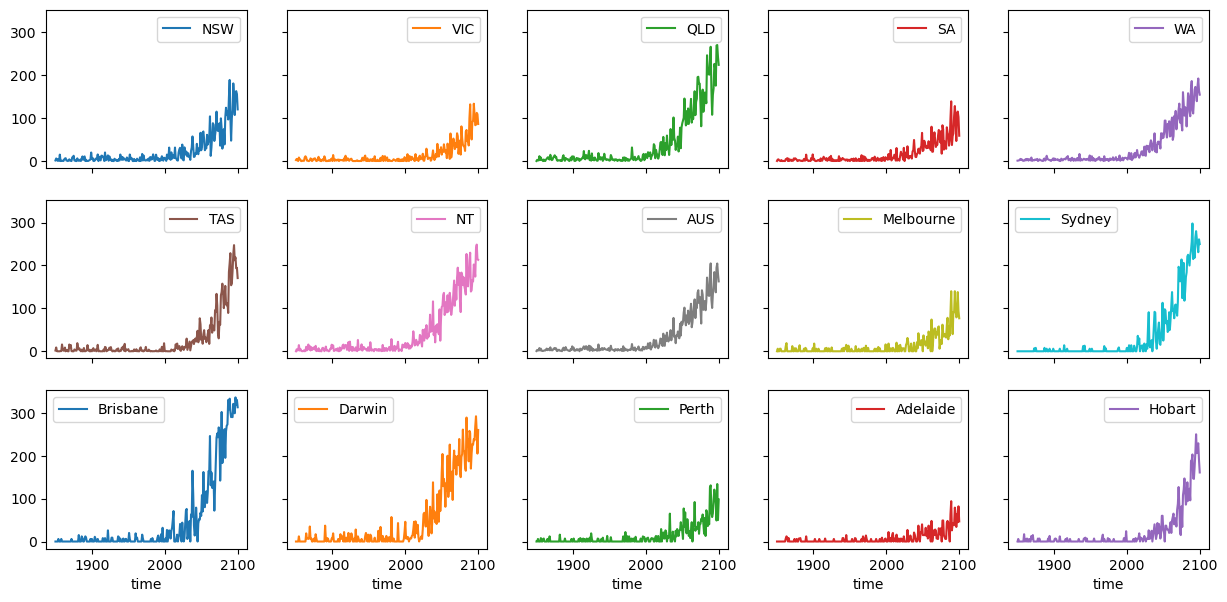

In [53]:
df.plot(
    figsize=[15, 7],
    subplots=True,
    layout=[3,5],
    sharey=True,
#    kind='bar'
)
plt.show()

In [54]:
df.to_csv('/g/data/xv83/dbi599/treasury/wsdi_yr_ACCESS-ESM1-5_ssp370_r1i1p1f1_aus-states-cities_1850-2100.csv')